# Analysis of hippocampal theta sweeps

***Sidney Rafilson | Buzsaki Lab***



This notebook loads the preprocessed electrophysiology (CatGT -> Kilosort4 -> CellMetrics) and tracking data, builds spike rate matrices and place fields and implements bayessian decoding

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.io import loadmat
from scipy.special import logsumexp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
import plotly.graph_objects as go

from core import *

## Pipeline configuration settings

In [ ]:
# ----------------------------- Config ---------------------------------

# Data paths and session info
DATA_DIR = r"\\research-cifs.nyumc.org\research\buzsakilab\Homes\voerom01\Use_dependent_sleep\UDS_R01\UDS_R01_20250212"
SESSION_NAME = "pre_homecage_g0"
PROBES = [0, 1, 2]


# Spike rate computation parameters
WINDOW_SIZE = 0.03          # s
STEP_SIZE   = 0.015        # s
SIGMA       = 2          # smoothing sigma (0 -> no smoothing)
USE_UNITS   = "good"       # {'all', 'good', 'mua'}
NORMALIZE   = True         # z-score each unit's rates

# Filtering thresholds
MIN_TOTAL_SPIKES   = 100
MIN_MEAN_RATE_HZ   = 0.01
MIN_PRESENCE_RATIO = 0.25
N_TIME_BINS        = 100    # coarse bins for presence ratio


# defining the region dictionary. Keys are probe numbers, values are dictionaries which are further mapping shanks to regions
region_dict = {0: {0: 'CA1', 1: 'RSP', 2: 'CA3', 3: 'CA1', 4: 'RSP', 5: 'CA3', 6: 'CA1', 7: 'RSP'}, 1: {0: 'CA3', 1: 'CA1', 2: 'CA2', 3: 'A1', 4: 'S1'}, 2: {0: 'CA3', 1: 'Th', 2: 'V1', 3: 'Th', 4: 'CA1', 5: 'V1', 6: 'CA1', 7: 'V1'}}
#region_dict = {0: {0: 'CA1', 1: 'Ctx', 2: 'CA3', 3: 'CA1', 4: 'Ctx', 5: 'CA3', 6: 'CA1', 7: 'Ctx'}, 1: {0: 'CA3', 1: 'CA1', 2: 'CA2', 3: 'Ctx', 4: 'Ctx'}, 2: {0: 'CA3', 1: 'Th', 2: 'Ctx', 3: 'Th', 4: 'CA1', 5: 'Ctx', 6: 'CA1', 7: 'Ctx'}}
#region_dict = {0: {0: 'HC', 1: 'Ctx', 2: 'HC', 3: 'HC', 4: 'Ctx', 5: 'HC', 6: 'HC', 7: 'Ctx'}, 1: {0: 'HC', 1: 'HC', 2: 'HC', 3: 'Ctx', 4: 'Ctx'}, 2: {0: 'HC', 1: 'Th', 2: 'Ctx', 3: 'Th', 4: 'HC', 5: 'Ctx', 6: 'HC', 7: 'Ctx'}}



In [3]:
# ------------------------ Optionally save & load region dictionary ------------------------
save_region_dict = True
if save_region_dict:
    dict_file = open(os.path.join(DATA_DIR, 'region_dict.pkl'), 'wb')
    dict_file.write(str(region_dict).encode())
    dict_file.close()

load_region_dict = True
if load_region_dict:
    dict_file = open(os.path.join(DATA_DIR, 'region_dict.pkl'), 'rb')
    region_dict = eval(dict_file.read().decode())
    dict_file.close()


## Loading the spike rate matrices

In [4]:
# ------------------------ Load spike rate matrices ------------------------
spike_rate_matrices = {}
cell_types = {}
regions = {}
for probe in PROBES:
    # Get the raw spike counts and the zscored and smoothed spike rates
    ks_dir = os.path.join(DATA_DIR, 'preprocessing_output', f'supercat_{SESSION_NAME}', f'{SESSION_NAME}_imec{probe}', f'imec{probe}_ks4')
    raw_rates, time_bins, units = compute_spike_rates(str(ks_dir), WINDOW_SIZE, STEP_SIZE, USE_UNITS, 0.0, False)
    spike_rate_matrix, _, _ = compute_spike_rates(str(ks_dir), WINDOW_SIZE, STEP_SIZE, USE_UNITS, SIGMA, NORMALIZE)
    est_counts_per_bin = raw_rates * WINDOW_SIZE


    # computing the filtering metrics
    total_spikes   = est_counts_per_bin.sum(axis=1)         
    mean_rate_hz   = raw_rates.mean(axis=1)
    presence_ratio = get_presence_ratio(est_counts_per_bin, time_bins, N_TIME_BINS)

    mask = (
        (total_spikes >= MIN_TOTAL_SPIKES) &
        (mean_rate_hz >= MIN_MEAN_RATE_HZ) &
        (presence_ratio >= MIN_PRESENCE_RATIO)
    )


    # Apply mask to spike rate matrix and unit list
    spike_rate_matrix = spike_rate_matrix[mask, :]
    units = [u for u, keep in zip(units, mask) if keep]
    print(f"Probe {probe}: Keeping {mask.sum()} / {mask.sum() + (~mask).sum()} units after filtering.\nspike_rate_matrix shape: {spike_rate_matrix.shape}\n")

    # remove units based on presence ratio
    spike_rate_matrices[probe] = (spike_rate_matrix, time_bins, units)


    # Load the cell metrics
    cell_metrics_file = os.path.join(DATA_DIR, 'preprocessing_output', f'supercat_{SESSION_NAME}', f'{SESSION_NAME}_imec{probe}', f'{SESSION_NAME}_tcat.imec{probe}.ap.cell_metrics.cellinfo.mat')
    cell_type = loadmat(cell_metrics_file)['cell_metrics']['putativeCellType'][0,0].flatten()
    shank_ids = loadmat(cell_metrics_file)['cell_metrics']['shankID'][0,0].flatten()


    # keeping only the string labels
    cell_type = np.array([ct[0] if isinstance(ct, np.ndarray) else ct for ct in cell_type])

    # removing mask applied units from cell type
    cell_types[probe] = cell_type[mask]
    regions[probe] = np.array([region_dict[probe][shank_id-1] for shank_id in shank_ids[mask]])  # shank IDs are 1-based

Probe 0: Keeping 105 / 126 units after filtering.
spike_rate_matrix shape: (105, 246291)

Probe 1: Keeping 307 / 330 units after filtering.
spike_rate_matrix shape: (307, 246291)

Probe 2: Keeping 103 / 109 units after filtering.
spike_rate_matrix shape: (103, 246291)



## Plotting spike rates by region

In [5]:
# --- Configuration ---
regions_of_interest = ['Th', 'CA1', 'CA2', 'CA3', 'RSP', 'A1', 'S1', 'V1']

cell_type_groups = {
    'Pyramidal':   ['Pyramidal Cell'],
    'Interneuron': ['Narrow Interneuron', 'Wide Interneuron'],
}

facet_by = "celltype"  # ignored below; we force "one heatmap per cell type"

# get the time bins from the first probe
first_probe = PROBES[0]
_, time_bins, _ = spike_rate_matrices[first_probe]


# -----------------------------
# 1) Collect matrices by (celltype, region) for global vmin/vmax
# -----------------------------
per_celltype_region = {}  # dict[celltype][region] = matrix (unsorted)
all_vals_for_scale = []

for celltype_key in cell_type_groups.keys():
    per_celltype_region[celltype_key] = {}
    for region_name in regions_of_interest:
        M = collect_matrix_for(
            spike_rate_matrices, region_name, regions,
            celltype_key, cell_types, PROBES, cell_type_groups
        )
        per_celltype_region[celltype_key][region_name] = M
        if M is not None and M.size > 0:
            all_vals_for_scale.append(M.ravel())

if len(all_vals_for_scale) == 0:
    raise RuntimeError("No units found for the chosen regions/cell types after filtering.")

all_vals = np.concatenate(all_vals_for_scale)
vmin = np.percentile(all_vals, 2.5)
vmax = np.percentile(all_vals, 97.5)


# -----------------------------
# 2) Build per-celltype concatenated heatmaps (sorted region-by-region)
# -----------------------------
def build_concatenated_sorted(M_by_region, sort_mode='corr'):
    """
    Input: dict[region] -> M
    Returns:
      M_concat: vertically concatenated heatmap (regions stacked)
      sections: list of (region_name, start_row, end_row) in M_concat
    """
    blocks = []
    sections = []
    row_cursor = 0
    for region_name in regions_of_interest:
        M = M_by_region.get(region_name, None)
        if M is None or M.size == 0:
            continue
        M_sorted = sort_units(M, mode=sort_mode)
        nrows = M_sorted.shape[0]
        blocks.append(M_sorted)
        sections.append((region_name, row_cursor, row_cursor + nrows))
        row_cursor += nrows

    if len(blocks) == 0:
        return None, []

    M_concat = np.vstack(blocks)
    return M_concat, sections


# Build concatenated matrices for each cell type
concat_by_celltype = {}
sections_by_celltype = {}
for celltype_key in cell_type_groups.keys():
    print(f"Building concatenated matrix for cell type: {celltype_key}")
    M_concat, sections = build_concatenated_sorted(per_celltype_region[celltype_key], sort_mode='corr')
    concat_by_celltype[celltype_key] = M_concat
    sections_by_celltype[celltype_key] = sections




Building concatenated matrix for cell type: Pyramidal
Building concatenated matrix for cell type: Interneuron


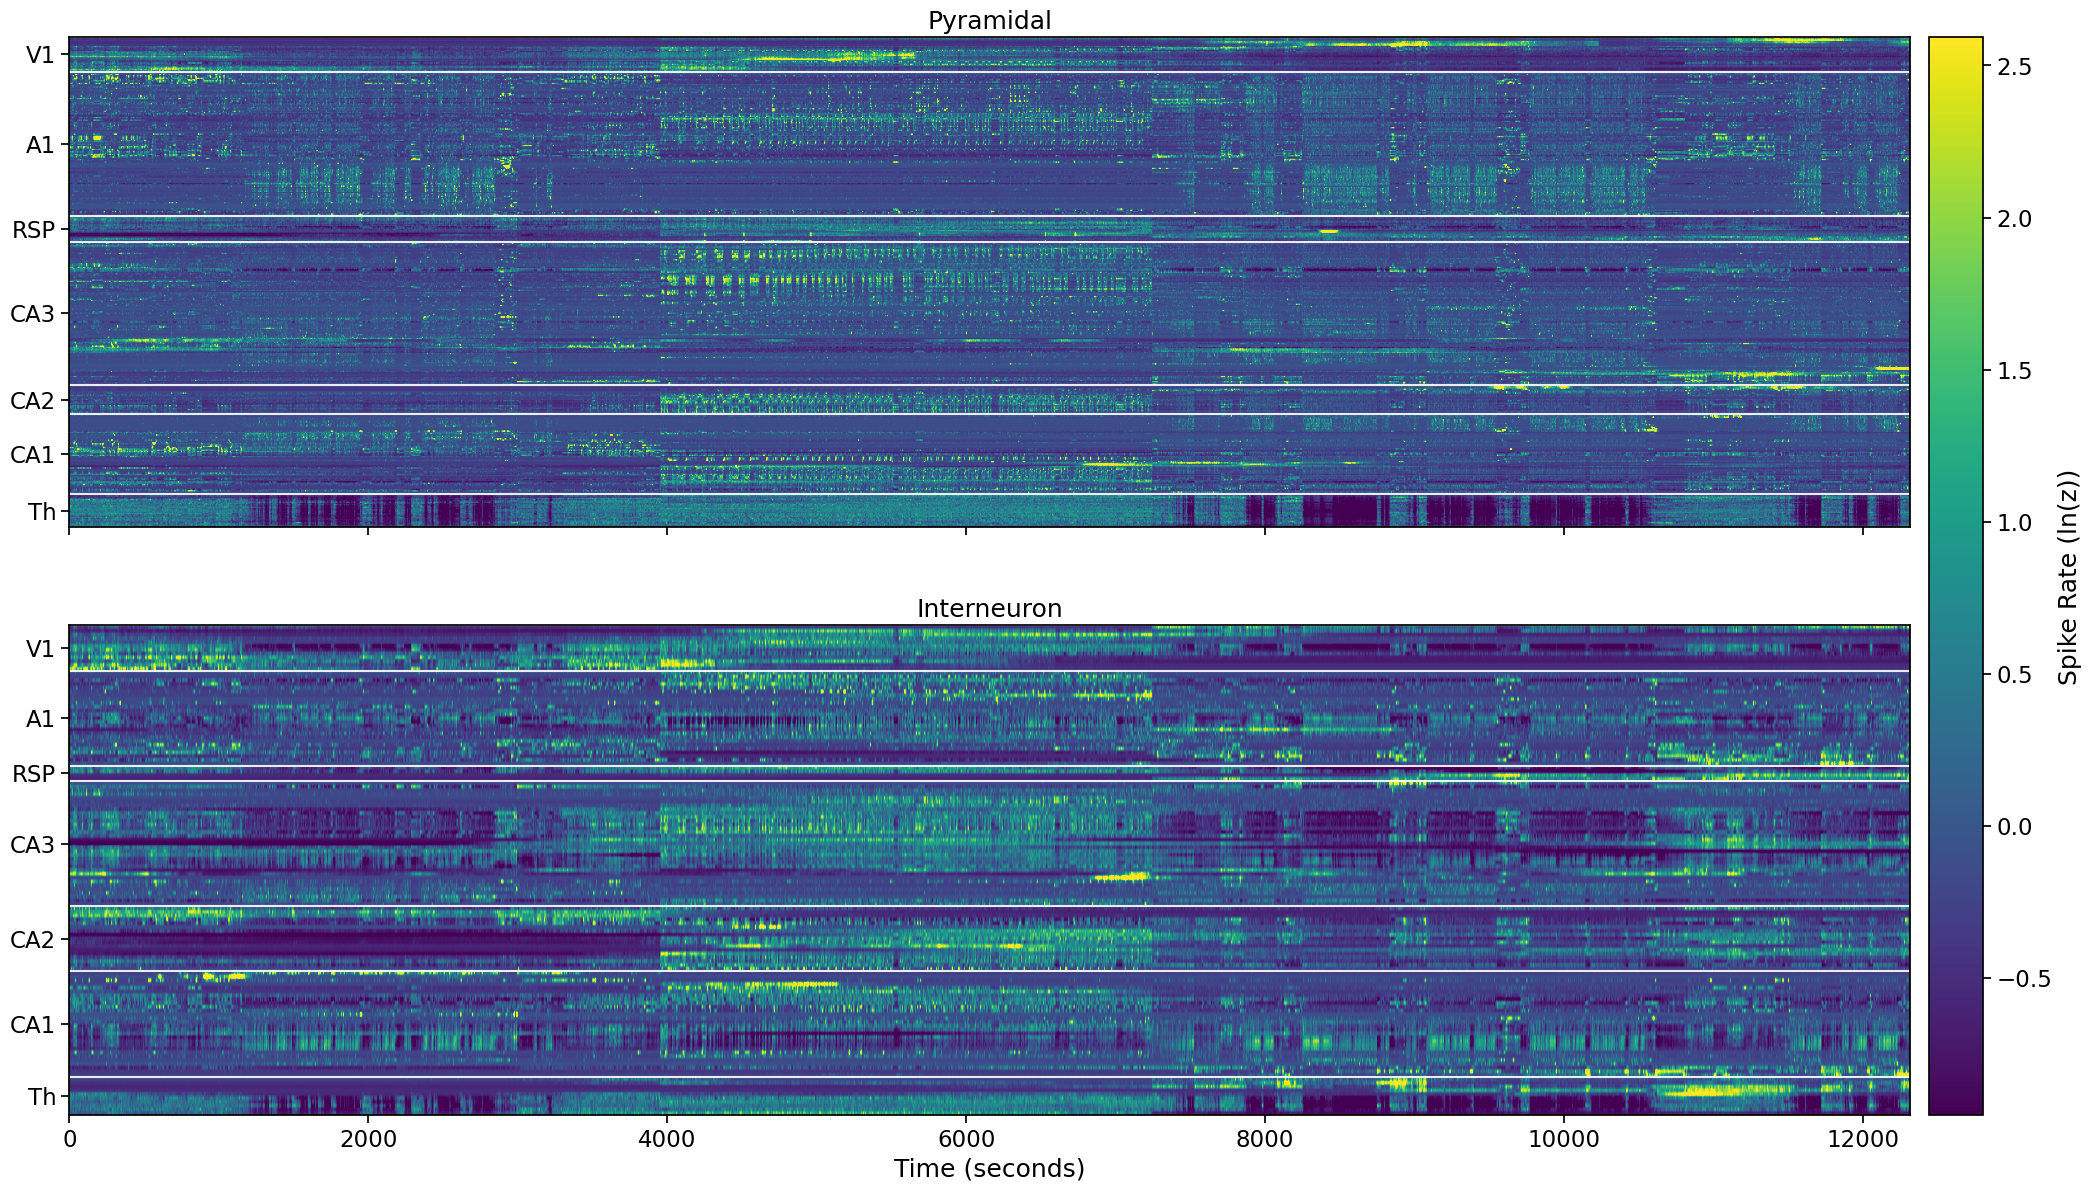

In [6]:
# -----------------------------
# 3) Plot: one heatmap per celltype
# -----------------------------
celltype_order = list(cell_type_groups.keys())  # e.g., ["Pyramidal", "Interneuron"]
n_rows = len(celltype_order)

fig, axs = plt.subplots(
    n_rows, 1,
    figsize=(25, 7 * n_rows),
    sharex=True,
    squeeze=False
)

first_im = None
visible_axes = []

for i, celltype_key in enumerate(celltype_order):
    ax = axs[i, 0]
    M_concat = concat_by_celltype[celltype_key]

    if M_concat is None or M_concat.size == 0:
        ax.set_visible(False)
        continue

    im = ax.imshow(
        M_concat,
        aspect='auto',
        cmap='viridis',
        extent=[time_bins[0], time_bins[-1], 0, M_concat.shape[0]],
        vmin=vmin,
        vmax=vmax,
        origin='lower'
    )
    if first_im is None:
        first_im = im
    visible_axes.append(ax)

    # --- Draw region separators and centered labels ---
    sections = sections_by_celltype[celltype_key]
    ytick_positions = []
    ytick_labels = []

    for (region_name, start_row, end_row) in sections:
        # Separator line at the top of each region except the first
        if start_row > 0:
            ax.axhline(y=start_row, color='white', linewidth=1.5, alpha=0.9)
        # Center position for label
        center = 0.5 * (start_row + end_row)

        ytick_positions.append(center)
        ytick_labels.append(region_name)

    # Add a bottom boundary line for the last region
    if sections:
        ax.axhline(y=sections[-1][2], color='white', linewidth=1.5, alpha=0.9)

    ax.set_yticks(ytick_positions)
    ax.set_yticklabels(ytick_labels)
    #ax.set_ylabel(f"{celltype_key}\n")

    # Title per heatmap
    ax.set_title(f"{celltype_key}")

# Shared x label
axs[-1, 0].set_xlabel("Time (seconds)")

# Single shared colorbar
if first_im is not None:
    cbar = fig.colorbar(first_im, ax=visible_axes, orientation='vertical', fraction=0.04, pad=0.01)
    cbar.set_label("Spike Rate (ln(z))")


#plt.savefig("firing_rates.png", dpi=300)

plt.show()



## Extracting the position tracking data 

Number of TTLs: 393621
Number of frames: 393557
Trimming TTLs from 393621 to 393557
Tracking start time: 3960.955 s, end time: 7240.426 s, duration: 3279.471 s


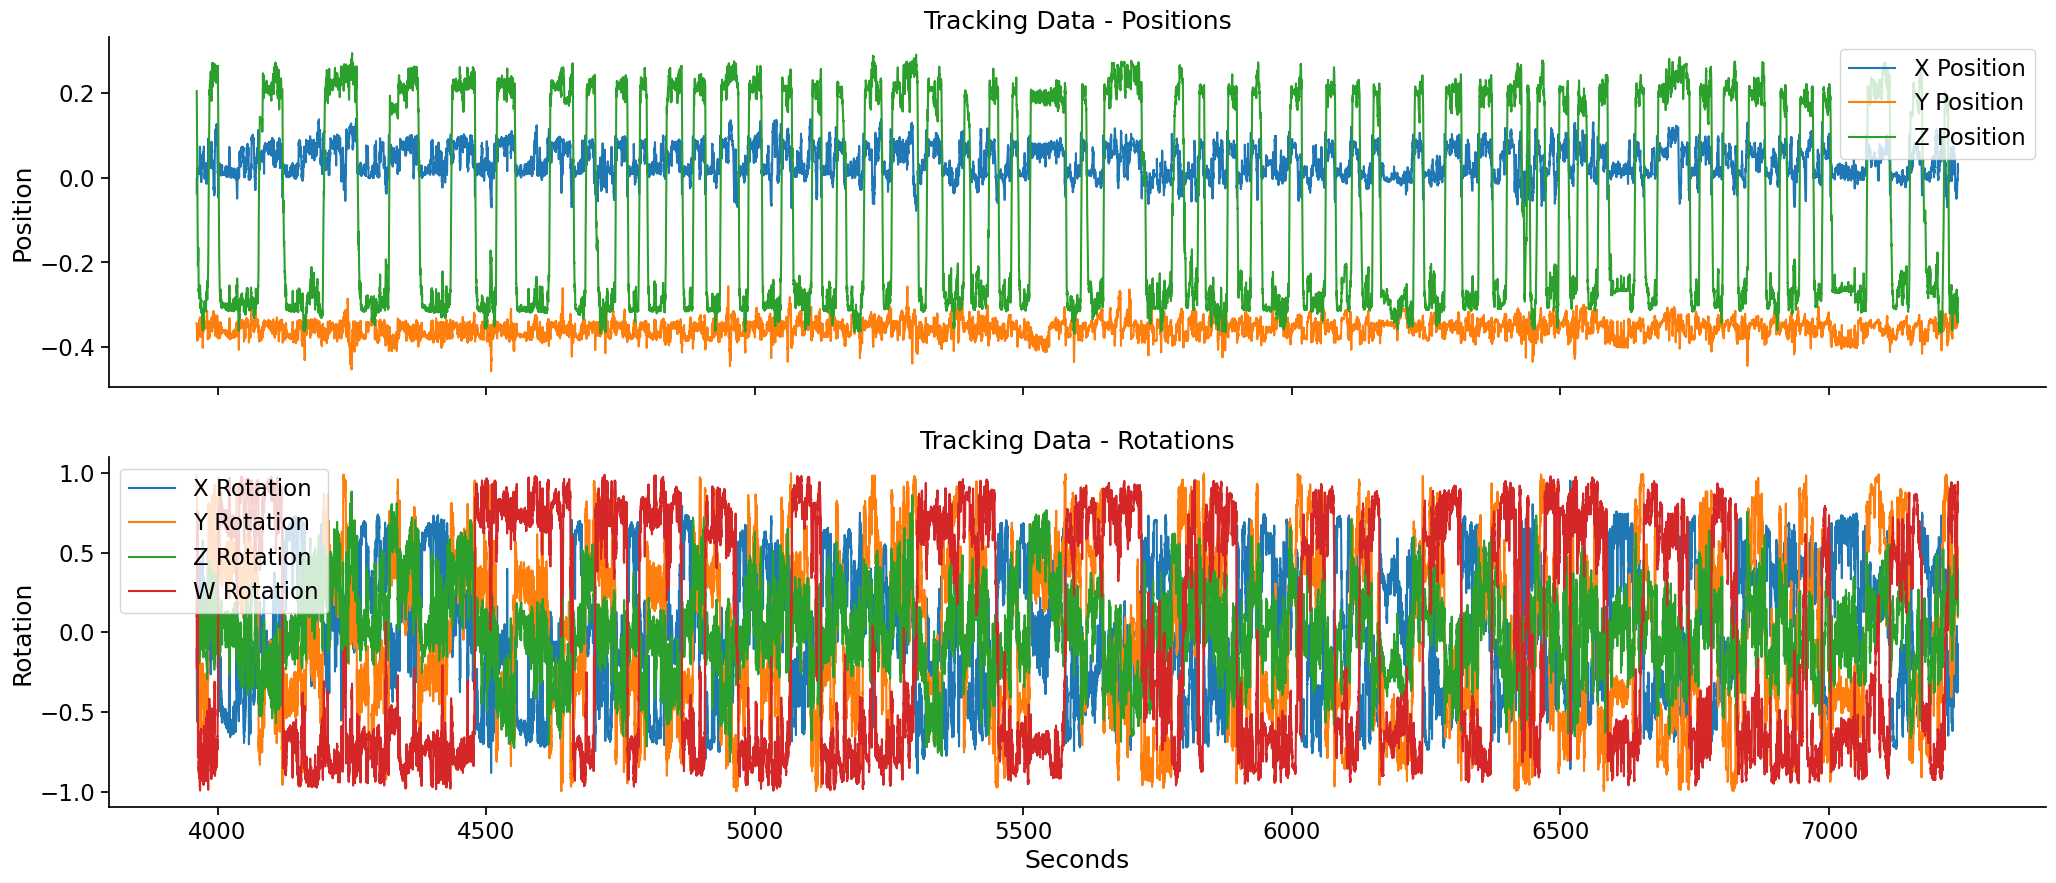

In [7]:
# Loadding in the TTLs
ttl_file = os.path.join(DATA_DIR, 'preprocessing_output', f'supercat_{SESSION_NAME}', f'{SESSION_NAME}_tcat.obx0.obx.xd_8_12_0.txt')
ttls = np.loadtxt(ttl_file)
print(f"Number of TTLs: {len(ttls)}")

# Loadding in the tracking data
tracking_file = os.path.join(DATA_DIR, "linear_maze_20250212.csv")
tracking_data = np.genfromtxt(tracking_file, delimiter=",", skip_header=7)
frames = tracking_data[:,0]
print(f'Number of frames: {len(frames)}')


# Sometimes there are a few more frames after the last TTL or more TTLs than frames. We will trim the data to the shortest length.
if len(frames) < len(ttls):
    print(f'Trimming TTLs from {len(ttls)} to {len(frames)}')
    ttls = ttls[:len(frames)]
    tracking_data = tracking_data[:len(frames),:]
elif len(frames) > len(ttls):
    print(f'Trimming frames from {len(frames)} to {len(ttls)}')
    frames = frames[:len(ttls)]
    tracking_data = tracking_data[:len(ttls),:]

# printing the start and end times
print(f'Tracking start time: {ttls[0]:.3f} s, end time: {ttls[-1]:.3f} s, duration: {ttls[-1]-ttls[0]:.3f} s')


# fill missing values or nan with linear interpolation
for i in range(tracking_data.shape[1]):
    col = tracking_data[:,i]
    nans = np.isnan(col)
    if np.any(nans):
        not_nans = ~nans
        interp_func_col = interp1d(frames[not_nans], col[not_nans], bounds_error=False, fill_value="extrapolate")
        col[nans] = interp_func_col(frames[nans])
        tracking_data[:,i] = col

# extract x, y, z positions and rotations
x_rotations = tracking_data[:,2]
y_rotations = tracking_data[:,3]
z_rotations = tracking_data[:,4]
w_rotations = tracking_data[:,5]
x_positions = tracking_data[:,6]
y_positions = tracking_data[:,7]
z_positions = tracking_data[:,8]

# Plotting the tracking data
fig, axs = plt.subplots(2, 1, figsize=(25,10), sharex=True)

sns.lineplot(ax=axs[0], x=ttls, y=x_positions, label='X Position')
sns.lineplot(ax=axs[0], x=ttls, y=y_positions, label='Y Position')
sns.lineplot(ax=axs[0], x=ttls, y=z_positions, label='Z Position')
axs[0].set_ylabel('Position')
axs[0].set_title('Tracking Data - Positions')

sns.lineplot(ax=axs[1], x=ttls, y=x_rotations, label='X Rotation')
sns.lineplot(ax=axs[1], x=ttls, y=y_rotations, label='Y Rotation')
sns.lineplot(ax=axs[1], x=ttls, y=z_rotations, label='Z Rotation')
sns.lineplot(ax=axs[1], x=ttls, y=w_rotations, label='W Rotation')
axs[1].set_xlabel('Seconds')
axs[1].set_ylabel('Rotation')
axs[1].set_title('Tracking Data - Rotations')
sns.despine()
plt.show()


In [8]:
# choose which position to use
pos_raw = z_positions  # original position samples aligned to `frames` (units: cm)
assert frames.shape[0] == pos_raw.shape[0]

# compute the speed
speed = np.abs(np.gradient(pos_raw)) / np.gradient(ttls)  # speed in m/s

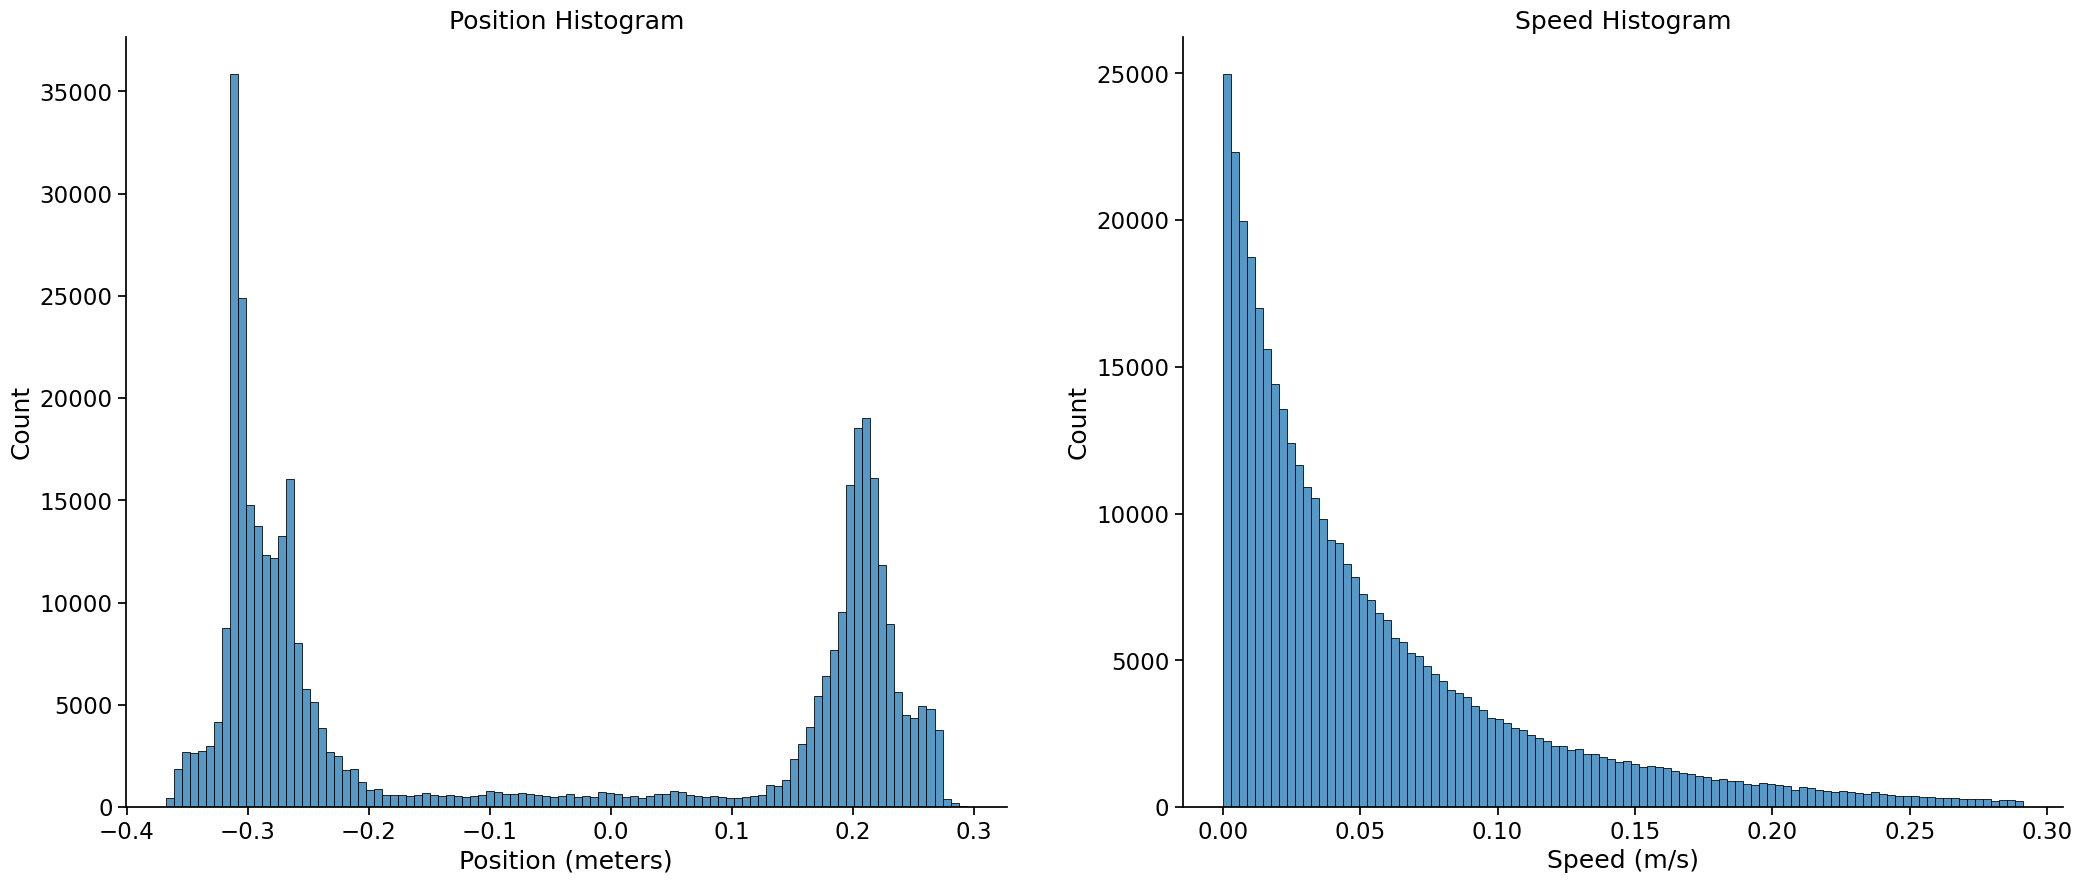

In [9]:
# Plotting some position statistics
fig, axs = plt.subplots(1, 2, figsize=(25,10))
sns.histplot(ax=axs[0], x=pos_raw, bins=100)
axs[0].set_xlabel('Position (meters)')
axs[0].set_ylabel('Count')
axs[0].set_title('Position Histogram')

sns.histplot(ax=axs[1], x=speed[speed < np.percentile(speed, 99)], bins=100)
axs[1].set_xlabel('Speed (m/s)')
axs[1].set_ylabel('Count')
axs[1].set_title('Speed Histogram')
sns.despine()
plt.show()


## Building and plotting place fields organized by probe

Probe 0: spike_rate_matrix=(105, 246291), time_bins=(246291,), units=105
Position shape after interpolation: (246291,)
Probe 1: spike_rate_matrix=(307, 246291), time_bins=(246291,), units=307
Position shape after interpolation: (246291,)
Probe 2: spike_rate_matrix=(103, 246291), time_bins=(246291,), units=103
Position shape after interpolation: (246291,)


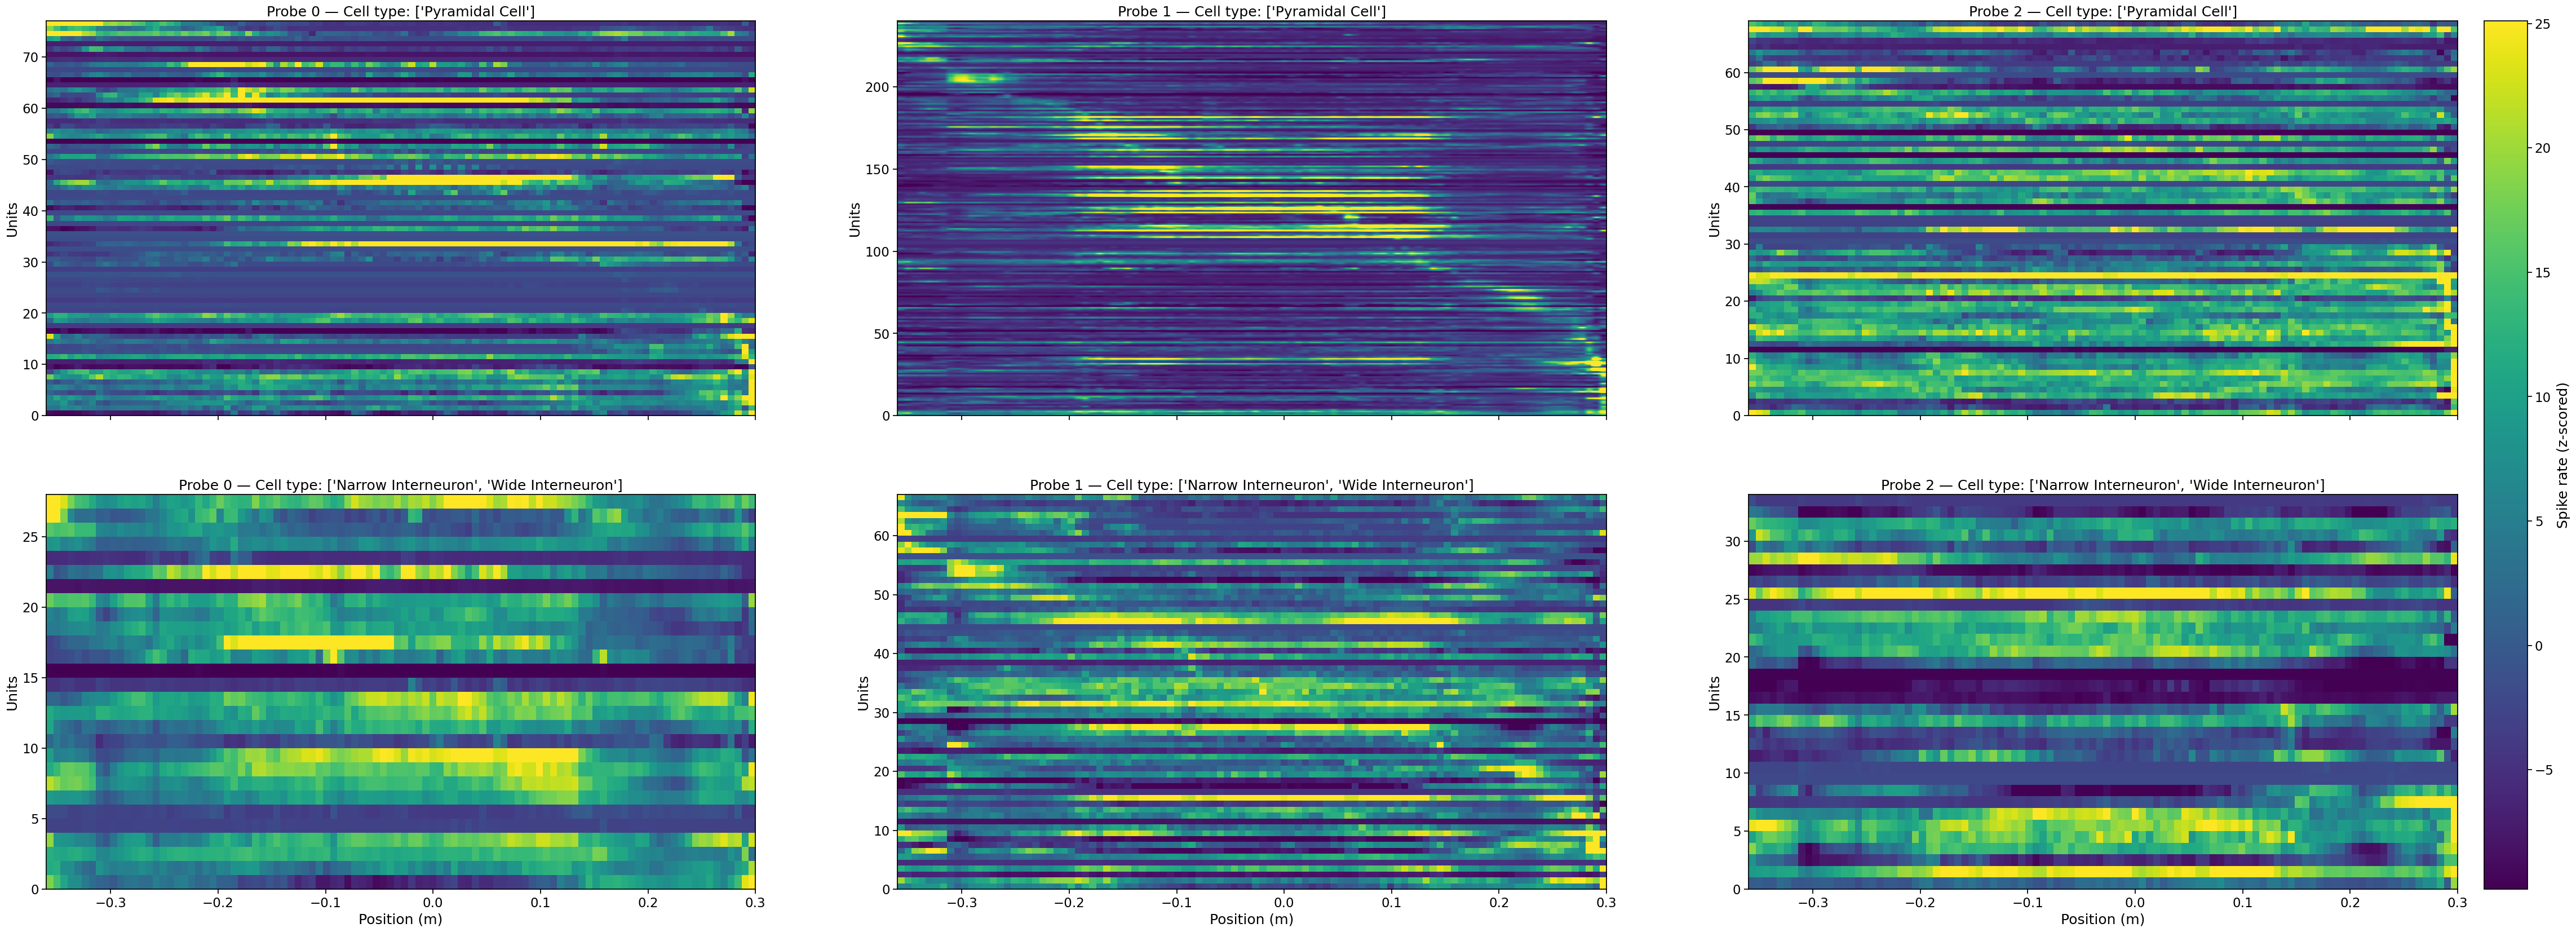

In [15]:
# -----------------------
# Config
# -----------------------
n_spatial_bins = 100
pos_min, pos_max = -0.36, 0.3
speed_threshold = 0.0  # m/s
cell_type_groups = {
    'Pyramidal':   ['Pyramidal Cell'],
    'Interneuron': ['Narrow Interneuron', 'Wide Interneuron'],
}
sort_by = 'peak'


# computing the spatial bin edges
bin_edges = np.linspace(pos_min, pos_max, n_spatial_bins + 1)

# Creating interpolation function for position
pos_interp_func = interp1d(ttls, pos_raw, kind = 'linear', bounds_error=False, fill_value=np.nan)

# All unique cell types across the selected probes
n_rows = max(1, len(cell_type_groups))
n_cols = max(1, len(PROBES))

fig, axs = plt.subplots(
    n_rows, n_cols,
    figsize=(20 * n_cols, 10 * n_rows),
    sharex=True,
    squeeze=False  # keep axs 2D even if rows/cols == 1
)

first_im = None  # first image we draw (for colorbar)
visible_axes = []  # collect visible axes for colorbar
all_place_fields = []  # dict[(probe, cell_type)] -> place field matrix

for i, probe in enumerate(PROBES):
    spike_rate_matrix, time_bins, units = spike_rate_matrices[probe]  # (n_units, n_timebins) time_bins are in seconds and represent the start of each bin
    ct_probe = np.asarray(cell_types[probe])                    # len == n_units
    print(f'Probe {probe}: spike_rate_matrix={spike_rate_matrix.shape}, time_bins={time_bins.shape}, units={len(units)}')


    # Interpolate position to the spike rate matrix time grid
    pos = pos_interp_func(time_bins)
    print(f'Position shape after interpolation: {pos.shape}')

    # Crop the spike rates to the TTL times
    valid_time = (time_bins >= np.min(ttls)) & (time_bins <= np.max(ttls))
    spike_rates = spike_rate_matrix[:, valid_time]
    time_bins = time_bins[valid_time]
    pos = pos[valid_time]


    # filtering based on speed
    speed = np.abs(np.gradient(pos, time_bins)) # speed in m/s
    move = speed > speed_threshold
    if move.sum() == 0:
        print(f"Probe {probe}: no samples exceed speed threshold ({speed_threshold} m/s).")
        for j in range(n_rows): axs[j, i].set_visible(False)
        continue

    # Apply speed mask
    spike_rates = spike_rates[:, move]
    pos = pos[move]
    time_bins = time_bins[move]

    # Map each timepoint to a spatial bin index
    idx = np.digitize(pos, bin_edges, right=True)  # 0..n_spatial_bins
    idx = np.clip(idx, 0, n_spatial_bins - 1)

    # Build dt aligned per sample: last sample inherits previous dt
    dt = np.empty_like(time_bins, dtype=float)
    dt[1:] = np.diff(time_bins)
    dt[0] = dt[1] if dt.size > 1 else 0.0
    dt = np.maximum(dt, 0.0)

    # Precompute occupancy once
    denom = np.bincount(idx, weights=dt, minlength=n_spatial_bins).astype(float)
    if denom.sum() == 0:
        print(f"Probe {probe}: zero occupancy across all bins.")
        for j in range(n_rows): axs[j, i].set_visible(False)
        continue

    # --- Per-cell-type loop (rows) ---
    for j, cell_type in enumerate(cell_type_groups):
        cell_type_label = cell_type_groups[cell_type]
        ax = axs[j, i]

        # unit indices for this cell type on this probe
        ct_indices = np.where(np.isin(ct_probe, cell_type_label))[0]
        if ct_indices.size == 0:
            ax.set_visible(False)
            continue

        # Build place fields for only those units
        place_fields = []
        for k in ct_indices:
            fr = spike_rates[k, :]
            num = np.bincount(idx, weights=fr, minlength=n_spatial_bins).astype(float)
            pf = np.divide(num, denom, out=np.zeros_like(num), where=(denom > 0))
            place_fields.append(pf)

        if len(place_fields) == 0:
            ax.set_visible(False)
            continue
        
        if sort_by == 'peak':
            # Sort by peak bin (within this cell type)
            pf_mat = np.vstack(place_fields)  # shape: (n_units_in_type, n_spatial_bins)
            order = np.argsort(np.argmax(pf_mat, axis=1))[::-1]  # earliest peak at top
            pf_mat = pf_mat[order, :]
        elif sort_by == 'corr':
            # Sort by correlation
            pf_mat = np.vstack(place_fields)  # shape: (n_units_in_type, n_spatial_bins)
            pf_mat = sort_units(pf_mat, mode='corr')

        # robust color scale per panel
        vmin = np.percentile(pf_mat, 2.5)
        vmax = np.percentile(pf_mat, 97.5)
        if vmin == vmax:  # edge case of constant activity
            vmax = vmin + 1e-9

        im = ax.imshow(
            pf_mat,
            aspect='auto',
            cmap='viridis',
            extent=[bin_edges[0], bin_edges[-1], 0, pf_mat.shape[0]],
            vmin=vmin, vmax=vmax,
            origin='lower'
        )

        if first_im is None:
            first_im = im
        visible_axes.append(ax)

        # Labels/titles
        if j == n_rows - 1:
            ax.set_xlabel('Position (m)')
        ax.set_ylabel('Units')
        ax.set_title(f'Probe {probe} — Cell type: {cell_type_label}')

        # Store place fields
        all_place_fields.append((probe, cell_type_label, np.array(pf_mat)))

# Colorbar across all visible panels
if first_im is not None and len(visible_axes) > 0:
    cbar = fig.colorbar(first_im, ax=visible_axes, orientation='vertical', fraction=0.07, pad=0.01)
    cbar.set_label('Spike rate (z-scored)')

plt.show()



## Plotting the place fields organized by region

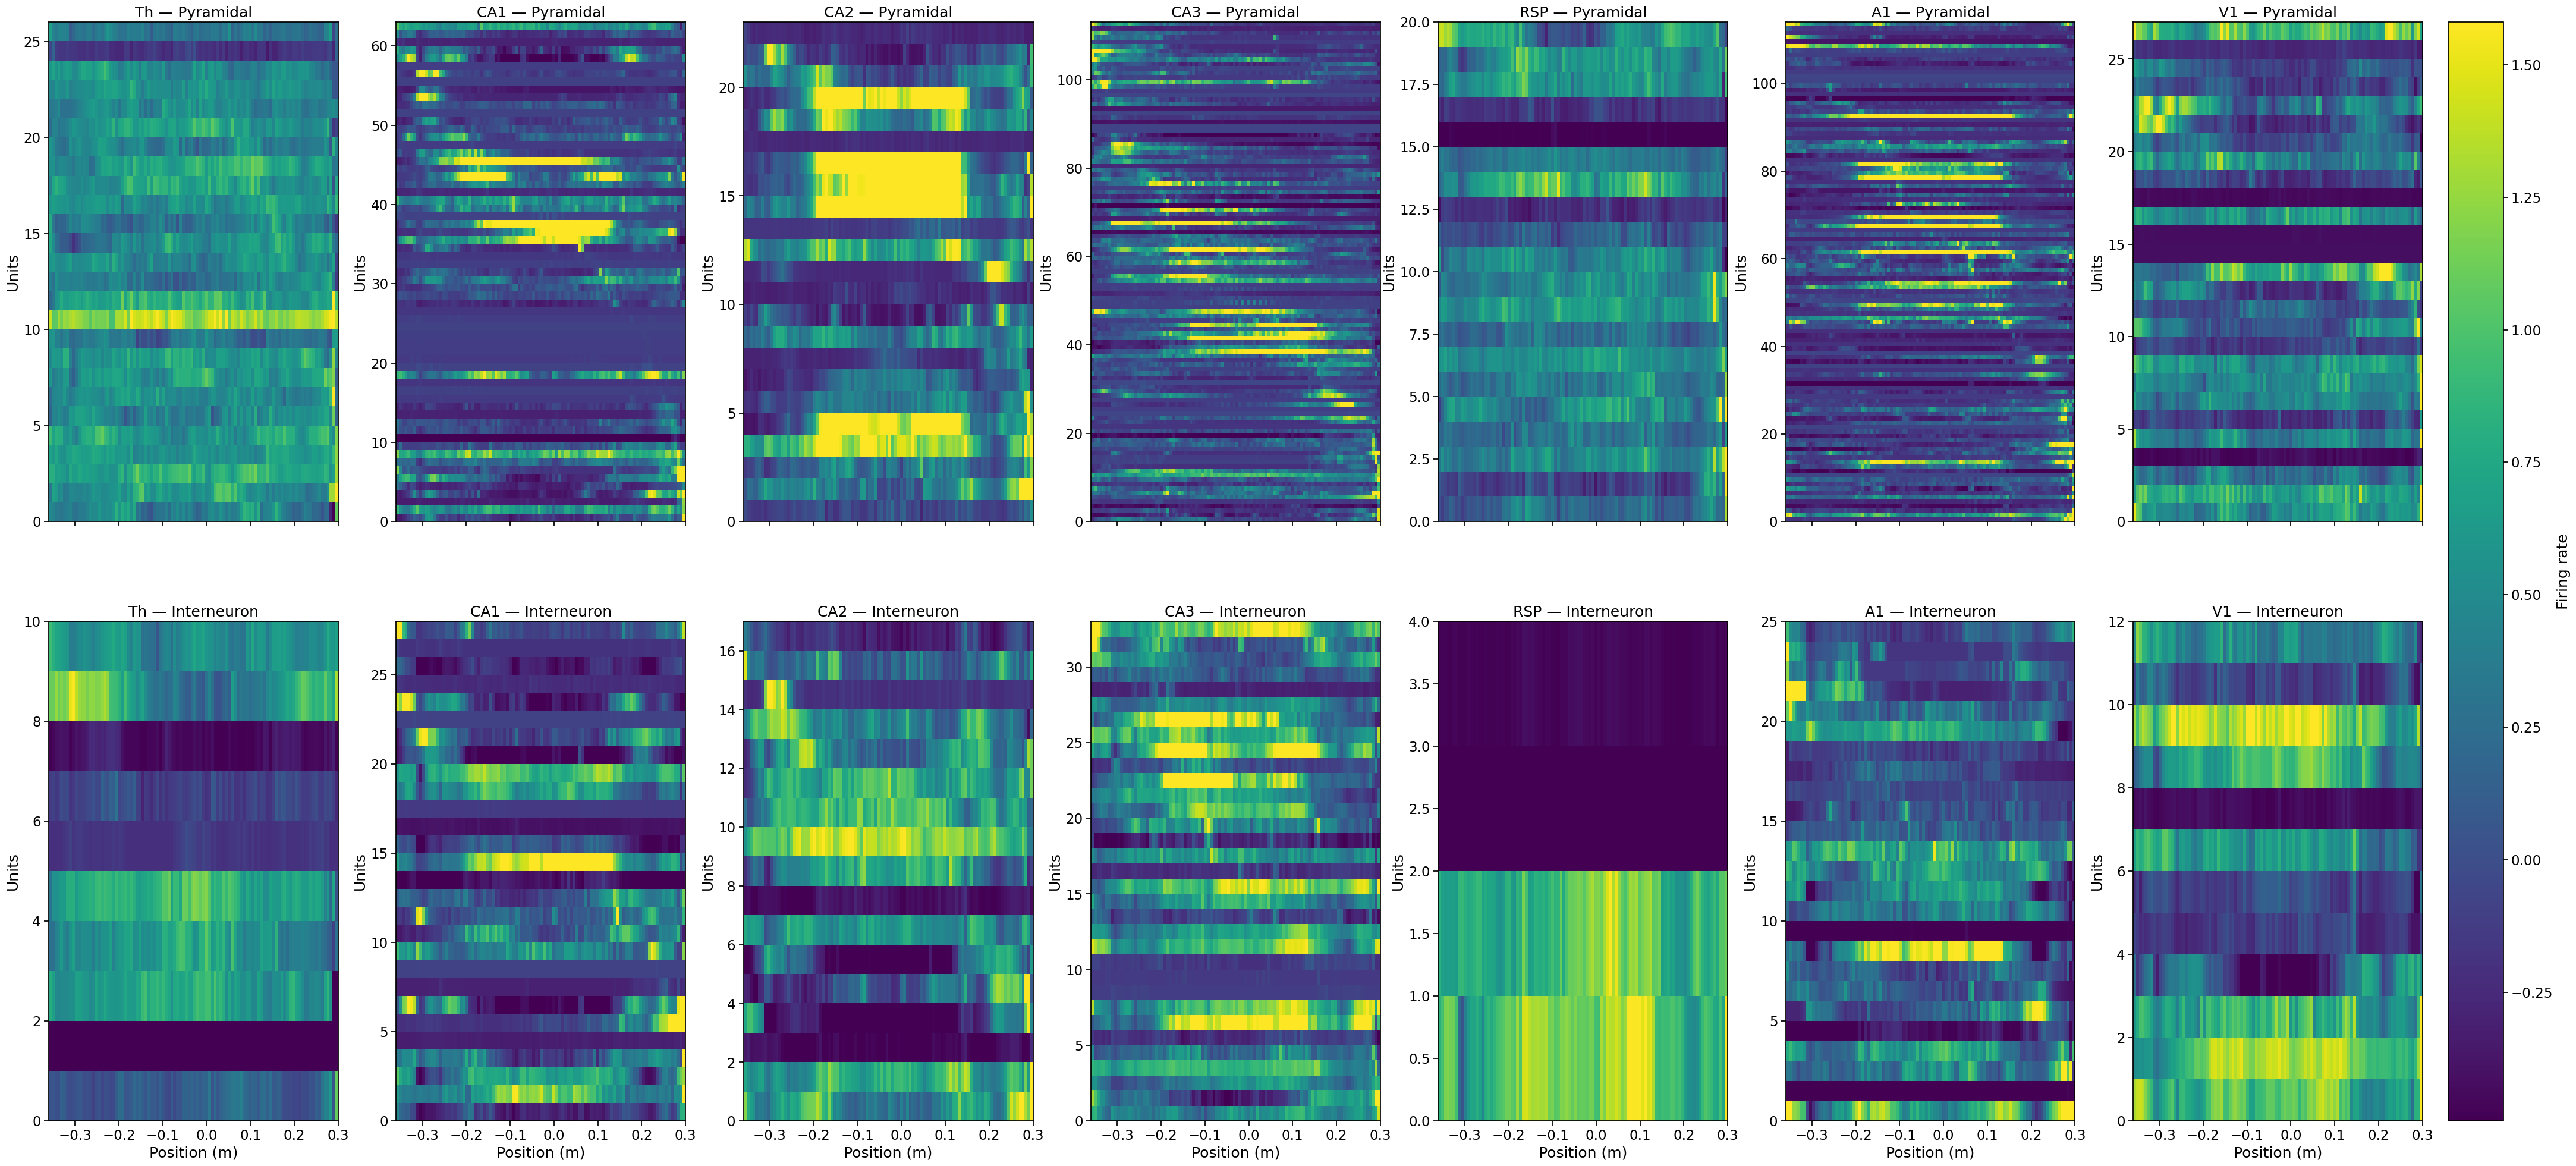

In [16]:
# --- Choose regions to show as columns ---
regions_of_interest = ['Th', 'CA1', 'CA2', 'CA3', 'RSP', 'A1', 'V1']

# Group the cell-metric labels into two families
cell_type_groups = {
    'Pyramidal':   ['Pyramidal Cell'],
    'Interneuron': ['Narrow Interneuron', 'Wide Interneuron'],
}


pos_interp_func = interp1d(ttls, pos_raw, bounds_error=False, fill_value=np.nan)

# -----------------------
# Precompute per-probe masks and occupancy
# -----------------------
probe_data = {}  # probe -> dict with masks, idx, denom, tb_m, pos_m, spike_rates_m
for probe in PROBES:
    spike_rate_matrix, tb, units = spike_rate_matrices[probe]  # (n_units, n_timebins)
    ct_probe = np.asarray(cell_types[probe])                    # len == n_units

    # Interpolate position to this probe’s time grid
    pos_probe = pos_interp_func(tb)

    # TTL crop
    start_time, end_time = np.min(ttls), np.max(ttls)
    valid_time = (tb >= start_time) & (tb <= end_time)

    fr = spike_rate_matrix[:, valid_time]
    tb_crop = tb[valid_time]
    pos_crop = pos_probe[valid_time]

    # Drop NaN position samples
    ok = ~np.isnan(pos_crop)
    if ok.sum() == 0:
        print(f"Probe {probe}: no valid samples after TTL/position masking.")
        probe_data[probe] = None
        continue

    fr = fr[:, ok]
    pos_crop = pos_crop[ok]
    tb_crop = tb_crop[ok]

    # Speed (smoothed) and moving-mask
    # gradient(pos, time) already gives velocity (m/s)
    speed = np.abs(np.gradient(pos_crop, tb_crop))
    speed = gaussian_filter1d(speed, sigma=3)

    move = speed > speed_threshold
    if move.sum() == 0:
        print(f"Probe {probe}: no samples exceed speed threshold ({speed_threshold} m/s).")
        probe_data[probe] = None
        continue

    # Apply moving mask
    fr_m   = fr[:, move]
    pos_m  = pos_crop[move]
    tb_m   = tb_crop[move]

    # Bin positions for this probe
    idx = np.digitize(pos_m, bin_edges, right=True)
    idx = np.clip(idx, 0, n_spatial_bins - 1)

    # Occupancy (counts per spatial bin) for this probe
    denom = np.bincount(idx, minlength=n_spatial_bins).astype(float)
    if denom.sum() == 0:
        print(f"Probe {probe}: zero occupancy across all bins.")
        probe_data[probe] = None
        continue

    probe_data[probe] = dict(
        fr_m=fr_m, tb_m=tb_m, pos_m=pos_m, idx=idx, denom=denom, ct=ct_probe
    )

# -----------------------
# Build per-(region, celltype) lists of place fields across probes
# -----------------------
panel_pfs = {}  # (row_key, col_key) -> list of 1D PF arrays
row_keys = ['Pyramidal', 'Interneuron']
col_keys = list(regions_of_interest)

# Helper to compute one unit's PF using its probe's occupancy
def unit_place_field(fr_unit, idx, denom):
    # weighted average rate per bin: sum(fr at timepoints in bin) / occupancy
    num = np.bincount(idx, weights=fr_unit, minlength=n_spatial_bins).astype(float)
    pf = np.divide(num, denom, out=np.zeros_like(num), where=(denom > 0))
    return pf

for rkey in row_keys:
    for ckey in col_keys:
        panel_pfs[(rkey, ckey)] = []

# We need unit-level region labels; `regions[probe]` already holds region per unit (after your earlier mask)
for probe in PROBES:
    pdata = probe_data.get(probe, None)
    if pdata is None:
        continue

    fr_m   = pdata['fr_m']       # (n_units_probe, n_timepoints_after_masks)
    idx    = pdata['idx']        # (n_timepoints_after_masks,)
    denom  = pdata['denom']      # (n_spatial_bins,)
    ct_arr = pdata['ct']         # (n_units_probe,)
    rgn_arr = regions[probe]     # (n_units_probe,) region name per unit

    for rkey in row_keys:
        allowed_ct = set(cell_type_groups[rkey])
        for ckey in col_keys:
            # Select units that are (this region, this cell-type)
            unit_sel = np.where((np.isin(ct_arr, list(allowed_ct))) & (rgn_arr == ckey))[0]
            if unit_sel.size == 0:
                continue

            # Compute PF per selected unit and append
            for u in unit_sel:
                pf = unit_place_field(fr_m[u, :], idx, denom)
                panel_pfs[(rkey, ckey)].append(pf)

# -----------------------
# Prepare matrices & global color scale
# -----------------------
panel_mats = {}  # (row_key, col_key) -> 2D array (n_units, n_bins) or None
all_vals = []

for rkey in row_keys:
    for ckey in col_keys:
        pf_list = panel_pfs[(rkey, ckey)]
        if len(pf_list) == 0:
            panel_mats[(rkey, ckey)] = None
            continue
        M = np.vstack(pf_list)  # (n_units_in_panel, n_spatial_bins)

        # Sort units by peak bin (descending so earlier peaks at top if you prefer)
        order = np.argsort(np.argmax(M, axis=1))[::-1]
        M = M[order, :]

        panel_mats[(rkey, ckey)] = M
        all_vals.append(M.ravel())

if len(all_vals) == 0:
    raise RuntimeError("No units found for the chosen regions/cell types after masking and binning.")

all_vals = np.concatenate(all_vals)
vmin = np.percentile(all_vals, 2.5)
vmax = np.percentile(all_vals, 97.5)
if vmin == vmax:
    vmax = vmin + 1e-12

# -----------------------
# Plot
# -----------------------
n_rows, n_cols = len(row_keys), len(col_keys)
fig, axs = plt.subplots(
    n_rows, n_cols,
    figsize=(8 * n_cols, 12 * n_rows),
    sharex=True,
    squeeze=False
)

first_im = None
visible_axes = []

for i, rkey in enumerate(row_keys):
    for j, ckey in enumerate(col_keys):
        ax = axs[i, j]
        M = panel_mats[(rkey, ckey)]
        if M is None or M.size == 0:
            ax.set_visible(False)
            continue

        im = ax.imshow(
            M,
            aspect='auto',
            cmap='viridis',
            extent=[bin_edges[0], bin_edges[-1], 0, M.shape[0]],
            vmin=vmin, vmax=vmax,
            origin='lower'
        )
        if first_im is None:
            first_im = im
        visible_axes.append(ax)

        title_txt = f"{ckey} — {rkey}"
        ax.set_title(title_txt)
        ax.set_ylabel("Units")
        if i == n_rows - 1:
            ax.set_xlabel("Position (m)")

# Shared colorbar
if first_im is not None and len(visible_axes) > 0:
    cbar = fig.colorbar(first_im, ax=visible_axes, orientation='vertical', fraction=0.07, pad=0.01)
    cbar.set_label("Firing rate")

plt.show()


In [ ]:
# save place fields line plots
output_dir = os.path.join(DATA_DIR, f'place_fields_window_size_{WINDOW_SIZE}_bins_{n_spatial_bins}')
os.makedirs(output_dir, exist_ok=True)

for (rkey, ckey), M in panel_mats.items():
    if M is None or M.size == 0:
        continue
    n_units = M.shape[0]
    for unit_idx in range(n_units):
        pf = M[unit_idx, :]
        plt.figure(figsize=(15,8))
        sns.lineplot(x = 0.5 * (bin_edges[:-1] + bin_edges[1:]), y = pf, linewidth=4)
        plt.title(f'Region: {ckey} — Cell type: {rkey} — Unit {unit_idx}')
        plt.xlabel('Position (m)')
        plt.ylabel('Firing Rate (Hz)')
        sns.despine()
        plot_file_path = os.path.join(output_dir, f'region_{ckey}', f'celltype_{rkey}')
        os.makedirs(plot_file_path, exist_ok=True)
        plot_filename = os.path.join(plot_file_path, f'unit{unit_idx}.png')
        plt.savefig(plot_filename)
        plt.close()

## Bayesian decoding of position from spiking activity

In [ ]:
# ---- Baysian decoding configuration ----
use_regions = ['CA1', 'CA2', 'CA3']
use_unit_types = ['Pyramidal Cell']
n_spatial_bins = 25
pos_min, pos_max = -0.36, 0.3
show_plots = True

# compute the spatial bin edges
bin_edges = np.linspace(pos_min, pos_max, n_spatial_bins + 1)

# choose which position to use
pos_raw = z_positions  # original position samples aligned to `frames` (units: cm)
assert frames.shape[0] == pos_raw.shape[0]

# Creating interpolation function for position
pos_interp_func = interp1d(ttls, pos_raw, kind = 'linear', bounds_error=False, fill_value=np.nan)

# getting the spike rates for the selected regions
selected_spike_rates = []
for probe in PROBES:
    spike_rate_matrix, tb, units = spike_rate_matrices[probe]  # (n_units, n_timebins)

    pos = pos_interp_func(tb)
    pos_idx = np.digitize(pos, bin_edges, right=True)

    # filtering out timebins outside the TTL range
    valid_time = (tb >= np.min(ttls)) & (tb <= np.max(ttls))
    print(valid_time.shape)
    spike_rate_matrix = spike_rate_matrix[:, valid_time]
    time_bins = tb[valid_time]
    pos_idx = pos_idx[valid_time]


    ct_probe = np.asarray(cell_types[probe])                    # len == n_units
    rgn_arr = regions[probe]                                   # len == n_units

    # select units from the selected regions
    unit_sel = np.where(
        (np.isin(ct_probe, use_unit_types)) &
        (np.isin(rgn_arr, use_regions))
    )[0]
    if unit_sel.size == 0:
        continue

    selected_spike_rates.append(spike_rate_matrix[unit_sel, :])

# concatenating the selected spike rates across probes
if len(selected_spike_rates) == 0:
    raise RuntimeError("No units found for the chosen regions after filtering.")
spike_rates_concat = np.vstack(selected_spike_rates)  # shape: (n_units_selected, n_timebins)

# sort the units based on correlation
spike_rates_concat = sort_units(spike_rates_concat, mode='corr')
vmin = np.percentile(spike_rates_concat, 2.5)
vmax = np.percentile(spike_rates_concat, 97.5)



In [ ]:


# plotting the digitized positions and the spike rates
if show_plots:
    dt = np.median(np.diff(time_bins))
    n_units = spike_rates_concat.shape[0]
    xmin = time_bins[0] - 0.5*dt
    xmax = time_bins[-1] + 0.5*dt

    fig, axs = plt.subplots(2, 1, figsize=(25, 10), sharex=True, constrained_layout=True)

    # Top: line
    axs[0].plot(time_bins, pos_idx)
    axs[0].set_ylabel('Position Bin Index')
    axs[0].set_title('Digitized Position over Time')

    # Bottom: heatmap with true x via extent
    im = axs[1].imshow(
        spike_rates_concat, aspect='auto', origin='lower',
        extent=[xmin, xmax, 0, n_units],
        vmin=vmin, vmax=vmax, cmap='viridis'
    )

    # Force identical x-lims on both axes
    for ax in axs:
        ax.set_xlim(xmin, xmax)

    # Colorbar attached to BOTH axes so layout stays symmetric
    cbar = fig.colorbar(im, ax=axs, location='right', fraction=0.02, pad=0.02)
    cbar.set_label('Z-scored Spike Rate')

    axs[1].set_xlabel('Time (Seconds)')
    axs[1].set_ylabel('Units (Concatenated)')
    axs[1].set_title('Concatenated Spike Rates Heatmap')

    plt.show()






In [ ]:
class DecoderDataset:
    """
    parameters:
    -----------
    X: (N, T) continuous features, e.g., spike rates
    Y: (T,) discrete targets in [0, K-1], e.g., position bin indices
    """

    def __init__(self, X: np.ndarray, Y: np.ndarray):
        if X.ndim != 2:
            raise ValueError("X must have shape (N, T)")
        if Y.ndim != 1:
            raise ValueError("Y must have shape (T,)")
        if X.shape[1] != Y.shape[0]:
            raise ValueError("X.shape[1] must equal Y.shape[0]")
        self.X = X
        self.Y = Y

    def split(self, k: int, k_CV: int = 10, n_blocks: int = 10):
        """
        Splits the dataset into training and testing sets for k-fold cross-validation.

        Returns:
        (X_train, Y_train), (X_test, Y_test), train_switch_ind, test_switch_ind
        """
        X_train, X_test, train_switch_ind, test_switch_ind = cv_split(self.X.T, k, k_CV, n_blocks)
        Y_train, Y_test, _, _ = cv_split(self.Y, k, k_CV, n_blocks)
        return (X_train.T, Y_train.T), (X_test.T, Y_test.T), train_switch_ind, test_switch_ind
    

class GaussianBayesDecoder:
    """
    A Gaussian Naive Bayes decoder for discrete states based on continuous observations.
    """

    def __init__(self, n_bins: int, var_floor: float = 1e-4, uniform_prior: bool = False):
        self.n_bins = n_bins
        self.var_floor = var_floor
        self.uniform_prior = uniform_prior

        self.mu_ = None
        self.var_ = None
        self.log_prior_ = None

    def fit(self, X: np.ndarray, Y: np.ndarray):
        """
        Fit the Gaussian Naive Bayes model to the training data.
        X: (N, T) features
        Y: (T,) labels
        """
        if X.ndim != 2 or Y.ndim != 1 or X.shape[1] != Y.shape[0]:
            raise ValueError("X must be (N, T) and Y must be (T,) with matching timepoints.")

        N, T = X.shape
        K = self.n_bins

        self.mu_ = np.zeros((N, K))
        self.var_ = np.zeros((N, K))
        self.log_prior_ = np.zeros(K)

        # Compute mean and variance per bin
        for k in range(K):
            idx = (Y == k)
            if np.any(idx):
                X_k = X[:, idx]
                self.mu_[:, k] = X_k.mean(axis=1)
                v = X_k.var(axis=1)
                self.var_[:, k] = np.maximum(v, self.var_floor)
            else:
                self.var_[:, k] = self.var_floor

        # Compute priors
        if self.uniform_prior:
            self.log_prior_[:] = -np.log(K)
        else:
            counts = np.bincount(Y, minlength=K)
            probs = (counts + 1) / (counts.sum() + K)  # Laplace smoothing
            self.log_prior_ = np.log(probs)

        return self

    def predict_log_probabilities(self, X: np.ndarray):
        """
        Predict log-probabilities log p(y=k | x)
        Returns: (K, T)
        """
        if self.mu_ is None or self.var_ is None or self.log_prior_ is None:
            raise RuntimeError("Model must be fitted before calling predict_log_probabilities().")

        N, T = X.shape
        K = self.n_bins
        log_probs = np.zeros((K, T))
        two_pi = 2 * np.pi

        for k in range(K):
            mu_k = self.mu_[:, [k]]
            var_k = self.var_[:, [k]]
            const_term = -0.5 * np.sum(np.log(two_pi * var_k))
            quad_term = -0.5 * np.sum(((X - mu_k) ** 2) / var_k, axis=0)
            log_probs[k, :] = const_term + quad_term + self.log_prior_[k]

        # numerical stability
        m = log_probs.max(axis=0, keepdims=True)
        return log_probs - m

    def predict(self, X: np.ndarray):
        """Return MAP class indices (argmax over log-probabilities)."""
        return np.argmax(self.predict_log_probabilities(X), axis=0)


In [ ]:
# running the decoder
dataset = DecoderDataset(spike_rates_concat, pos_idx)
decoder = GaussianBayesDecoder(n_bins=n_spatial_bins, var_floor=1e-4, uniform_prior=True)

# split the dataset into training and testing sets
(X_train, Y_train), (X_test, Y_test), train_switch_ind, test_switch_ind = dataset.split(k=0, k_CV=5, n_blocks=5)

print(f"Training set: X_train={X_train.shape}, Y_train={Y_train.shape}")
print(f"Testing set: X_test={X_test.shape}, Y_test={Y_test.shape}")
print(f"train_switch_ind shape: {train_switch_ind.shape}, test_switch_ind shape: {test_switch_ind.shape}")

# fit the decoder
decoder.fit(X_train, Y_train)

# predict on the test set
log_probs_test = decoder.predict_log_probabilities(X_test)  # shape: (n_bins, n_timepoints)
log_post = log_probs_test - logsumexp(log_probs_test, axis=0, keepdims=True)  # normalize to get log posterior
to_plot = np.exp(log_post)  # shape: (n_bins, n_timepoints)
Y_pred_test = decoder.predict(X_test)  # shape: (n_timepoints,)

# plot the log_probs heatmap for the test set with the true positions overlaid
if show_plots:
    n_timepoints = log_probs_test.shape[1]
    indicies = np.arange(n_timepoints)  # x-axis for plotting

    fig, axs = plt.subplots(2, 1, figsize=(25, 10), sharex=True, constrained_layout=True)

    # Top: line
    axs[0].plot(indicies, Y_test, label='True Position', color='blue')
    axs[0].plot(indicies, Y_pred_test, label='Predicted Position', color='orange', alpha=0.7)
    for switch in test_switch_ind:
        axs[0].axvline(x=switch, color='red', linestyle='--', alpha=0.5)
        axs[1].axvline(x=switch, color='red', linestyle='--', alpha=0.5)
    axs[0].set_ylim(0, n_spatial_bins - 1)
    axs[0].set_ylabel('Position Bin Index')
    axs[0].set_title('True vs Predicted Position Bin over Time')
    axs[0].legend()

    # Bottom: heatmap with true x via extent
    vmin = np.percentile(to_plot, 2.5)
    vmax = np.percentile(to_plot, 97.5)
    im = axs[1].imshow(
        to_plot, aspect='auto', origin='lower',
        cmap='viridis', vmin=vmin, vmax=vmax
    )
    # overlay true (solid) and predicted (dashed) positions
    axs[1].plot(indicies, Y_test, color='w', alpha=0.3, label='True Position', zorder=5)



    # Colorbar attached to BOTH axes so layout stays symmetric
    cbar = fig.colorbar(im, ax=axs, location='right', fraction=0.02, pad=0.02)
    cbar.set_label('Probability')

    axs[1].set_ylim(0, n_spatial_bins - 1)
    axs[1].set_xlabel('Time (bins)')
    axs[1].set_ylabel('Position Bins')
    axs[1].set_title('Decoded Probabilities Heatmap')
    axs[1].legend()

    plt.show()



## Training the decoder on the wake period and testing on durring sleep

In [ ]:
# ---- Baysian decoding configuration ----
use_regions = ['CA1', 'CA2', 'CA3']
use_unit_types = ['Pyramidal Cell']
n_spatial_bins = 25
pos_min, pos_max = -0.36, 0.3
show_plots = True

# compute the spatial bin edges
bin_edges = np.linspace(pos_min, pos_max, n_spatial_bins + 1)

# choose which position to use
pos_raw = z_positions  # original position samples aligned to `frames` (units: cm)
assert frames.shape[0] == pos_raw.shape[0]

# Creating interpolation function for position
pos_interp_func = interp1d(ttls, pos_raw, kind = 'linear', bounds_error=False, fill_value=np.nan)

# getting the spike rates for the selected regions
selected_spike_rates_wake = []
selected_spike_rates_sleep = []
for probe in PROBES:
    spike_rate_matrix, tb, units = spike_rate_matrices[probe]  # (n_units, n_timebins)

    pos = pos_interp_func(tb)
    pos_idx = np.digitize(pos, bin_edges, right=True)

    # filtering out timebins outside the TTL range
    wake_time = (tb >= np.min(ttls)) & (tb <= np.max(ttls))
    sleep_time = ~wake_time
    transition_point = np.searchsorted(tb, np.min(ttls))

    spike_rate_matrix_wake = spike_rate_matrix[:, wake_time]
    spike_rate_matrix_sleep = spike_rate_matrix[:, sleep_time]
    time_bins_wake = tb[wake_time]
    time_bins_sleep = tb[sleep_time]
    pos_idx = pos_idx[wake_time]


    ct_probe = np.asarray(cell_types[probe])                    # len == n_units
    rgn_arr = regions[probe]                                   # len == n_units

    # select units from the selected regions
    unit_sel = np.where(
        (np.isin(ct_probe, use_unit_types)) &
        (np.isin(rgn_arr, use_regions))
    )[0]
    if unit_sel.size == 0:
        continue

    selected_spike_rates_wake.append(spike_rate_matrix_wake[unit_sel, :])
    selected_spike_rates_sleep.append(spike_rate_matrix_sleep[unit_sel, :])

# concatenating the selected spike rates across probes
if (len(selected_spike_rates_wake) == 0 or len(selected_spike_rates_sleep) == 0):
    raise RuntimeError("No units found for the chosen regions after filtering.")
spike_rates_wake = np.vstack(selected_spike_rates_wake)  # shape: (n_units_selected, n_timebins)
spike_rates_sleep = np.vstack(selected_spike_rates_sleep)  # shape: (n_units_selected, n_timebins)




In [ ]:
decoder = GaussianBayesDecoder(n_bins=n_spatial_bins, var_floor=1e-4, uniform_prior=True)

# split the dataset into training and testing sets
X_train = spike_rates_wake
Y_train = pos_idx
X_test = spike_rates_sleep
Y_test = np.zeros(X_test.shape[1], dtype=int)  # dummy, as we don't have true positions during sleep

print(f"Training set: X_train={X_train.shape}, Y_train={Y_train.shape}")
print(f"Testing set: X_test={X_test.shape}, Y_test={Y_test.shape}")

# fit the decoder
decoder.fit(X_train, Y_train)

# predict on the test set
log_probs_test = decoder.predict_log_probabilities(X_test)  # shape: (n_bins, n_timepoints)
log_post = log_probs_test - logsumexp(log_probs_test, axis=0, keepdims=True)  # normalize to get log posterior
to_plot = np.exp(log_post).astype(np.float32)  # shape: (n_bins, n_timepoints)
Y_pred_test = decoder.predict(X_test)  # shape: (n_timepoints,)



In [ ]:


n_timepoints = log_probs_test.shape[1]
indicies = np.arange(n_timepoints) # x-axis for plotting
fig, axs = plt.subplots(2, 1, figsize=(25, 10), sharex=True, constrained_layout=True) # Top: line 
axs[0].plot(indicies, Y_pred_test, label='Predicted Position', color='orange', alpha=0.7) 
axs[0].set_ylim(0, n_spatial_bins - 1) 
axs[0].set_ylabel('Position Bin Index') 
axs[0].set_title('True vs Predicted Position Bin over Time') #plotting a line at the transition point from the pre and post sleep 
axs[0].axvline(x=transition_point, color='red', linestyle='--', alpha=0.5) 
axs[0].legend() # Bottom: heatmap with true x via extent 
vmin = np.percentile(to_plot, 2.5) 
vmax = np.percentile(to_plot, 97.5) 
im = axs[1].imshow(to_plot, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax ) # Colorbar attached to BOTH axes so layout stays symmetric 
cbar = fig.colorbar(im, ax=axs, location='right', fraction=0.02, pad=0.02) 
cbar.set_label('Probability') 
axs[1].set_ylim(0, n_spatial_bins - 1) 
axs[1].set_xlabel('Time (bins)') 
axs[1].set_ylabel('Position Bins') 
axs[1].set_title('Decoded Probabilities Heatmap')
plt.show()